In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
import glob
import os

First, load the data from the analysis H5 file and print some basic metadata.

In [3]:
# Specify the directory containing the .h5 files
folder_path = "/content/drive/MyDrive/Neuroscience/H5/Female adult C"

# Use glob to get all .h5 files in the specified folder
file_list = glob.glob(os.path.join(folder_path, "*.h5"))

# Initialize an empty list to hold the track data from each file
tracks_list = []

# Loop through each file and process
for idx, file_name in enumerate(file_list):
    with h5py.File(file_name, "r") as f:
        # Read and transpose the "tracks" dataset
        tracks = f["tracks"][:].transpose(3, 0, 2, 1)
        tracks_list.append(tracks)

        # For the first file, extract additional datasets and node names
        if idx == 0:
            edge_inds = f["edge_inds"][:]
            edge_names = f["edge_names"][:]
            node_names = [n.decode() for n in f["node_names"][:].tolist()]

# Concatenate all track data along the frames axis (axis=0)
trx = np.concatenate(tracks_list, axis=0)

# Get the new shape parameters
n_frames, n_tracks, n_nodes, _ = trx.shape

# Print out the details
print("Node names:", node_names)
print("Total Frames:", n_frames)
print("Tracks:", n_tracks)
print("Nodes:", n_nodes)

Node names: ['nose', 'left_ear', 'right_ear', 'neck', 'tail']
Total Frames: 98330
Tracks: 2
Nodes: 5


Here we just visualize the poses in a specific frame:

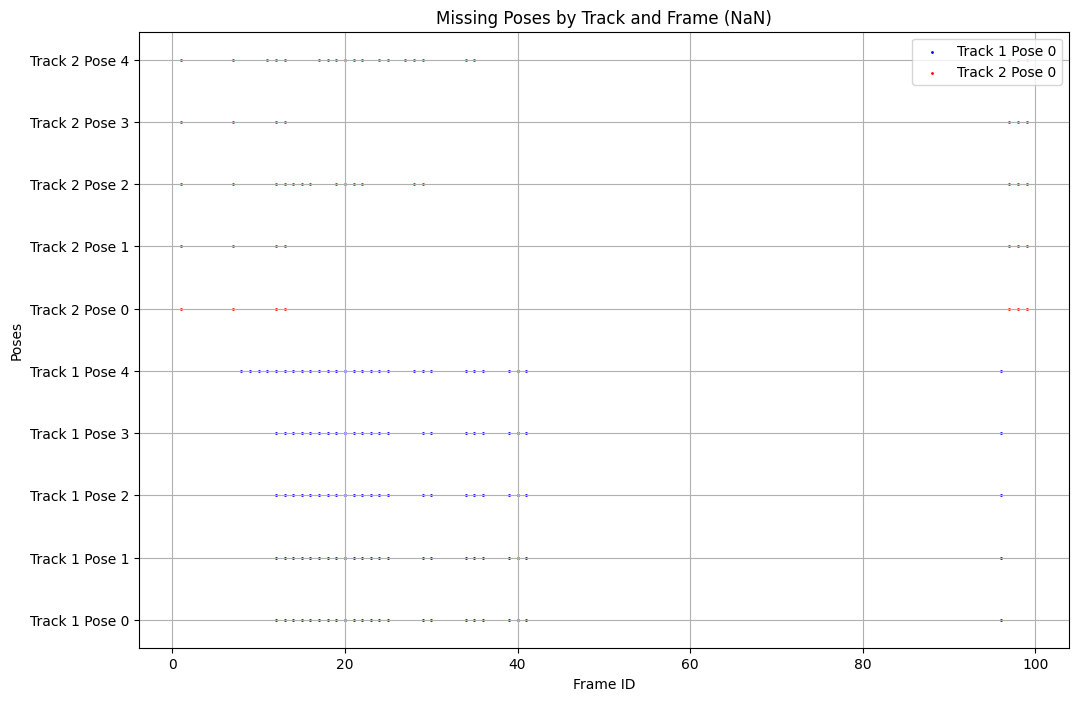

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Example data structure: trx[frame][track][pose][coordinates]
# Replace this with your actual data
missing_poses_track_1 = {}
missing_poses_track_2 = {}

# Initialize dictionaries to store missing frames for each pose
num_poses = len(trx[0][0])  # Assuming all frames have the same number of poses
start_frame = 1  # Starting frame ID
end_frame = 100    # Ending frame ID

for pose_idx in range(num_poses):
    missing_poses_track_1[pose_idx] = []
    missing_poses_track_2[pose_idx] = []

# Process frames to find where each pose is NaN
for fidx, frame in enumerate(trx[start_frame:end_frame]):  # Adjust frame range as needed
    actual_frame_id = start_frame + fidx  # Map fidx to actual frame ID
    # Check for NaN in each pose for Track 1
    for pose_idx, pose in enumerate(frame[0]):
        if np.isnan(pose).all():  # Check if the pose is NaN
            missing_poses_track_1[pose_idx].append(actual_frame_id)

    # Check for NaN in each pose for Track 2
    for pose_idx, pose in enumerate(frame[1]):
        if np.isnan(pose).all():  # Check if the pose is NaN
            missing_poses_track_2[pose_idx].append(actual_frame_id)

# Plotting missing frames
plt.figure(figsize=(12, 8), dpi=100)

# Track 1: Plot missing poses
for pose_idx, missing_frames in missing_poses_track_1.items():
    plt.scatter(
        missing_frames,
        [pose_idx + 1] * len(missing_frames),  # Y-values for each pose
        color="blue",
        s=1,  # Smaller marker size
        label=f"Track 1 Pose {pose_idx}" if pose_idx == 0 else ""
    )

# Track 2: Plot missing poses
for pose_idx, missing_frames in missing_poses_track_2.items():
    plt.scatter(
        missing_frames,
        [pose_idx + num_poses + 1] * len(missing_frames),  # Offset Y-values for Track 2
        color="red",
        s=1,  # Smaller marker size
        label=f"Track 2 Pose {pose_idx}" if pose_idx == 0 else ""
    )

# Labels and legend
y_ticks = list(range(1, num_poses + 1)) + list(range(num_poses + 1, 2 * num_poses + 1))
y_labels = [f"Track 1 Pose {i}" for i in range(num_poses)] + [f"Track 2 Pose {i}" for i in range(num_poses)]

plt.yticks(y_ticks, y_labels)
plt.xlabel("Frame ID")
plt.ylabel("Poses")
plt.title("Missing Poses by Track and Frame (NaN)")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()


In [5]:
# Get the index of the nodes of interest from their names.
nose_ind = node_names.index("nose")
tail_base_ind = node_names.index("tail")

# Pull out the coordinates for just those nodes.
noses = trx[:, :, nose_ind]
tail_bases = trx[:, :, tail_base_ind]

# Compute the distances across animals.
# Note that here we expand the tracks so we can compute all the pairwise distances.
nose_to_nose = np.linalg.norm(np.expand_dims(noses, axis=2) - np.expand_dims(noses, axis=1), axis=-1)
nose_to_tail_base = np.linalg.norm(np.expand_dims(noses, axis=2) - np.expand_dims(tail_bases, axis=1), axis=-1)

# nose_to_tail_base[t, i, j] = distance from nose i to tail j at time t
nose_to_tail_base.shape

(98330, 2, 2)

Processing /content/drive/MyDrive/Neuroscience/H5/Female adult C/801.000_801 interaction.analysis.h5...
Available nodes: ['nose', 'left_ear', 'right_ear', 'neck', 'tail']
Processing /content/drive/MyDrive/Neuroscience/H5/Female adult C/842.000_842 interaction.analysis.h5...
Available nodes: ['nose', 'left_ear', 'right_ear', 'neck', 'tail']
Processing /content/drive/MyDrive/Neuroscience/H5/Female adult C/853.000_853 interaction.analysis.h5...
Available nodes: ['nose', 'left_ear', 'right_ear', 'neck', 'tail']
Processing /content/drive/MyDrive/Neuroscience/H5/Female adult C/857.000_857 interaction.analysis.h5...
Available nodes: ['nose', 'left_ear', 'right_ear', 'neck', 'tail']
Processing /content/drive/MyDrive/Neuroscience/H5/Female adult C/910.000_910 interaction.analysis.h5...
Available nodes: ['nose', 'left_ear', 'right_ear', 'neck', 'tail']


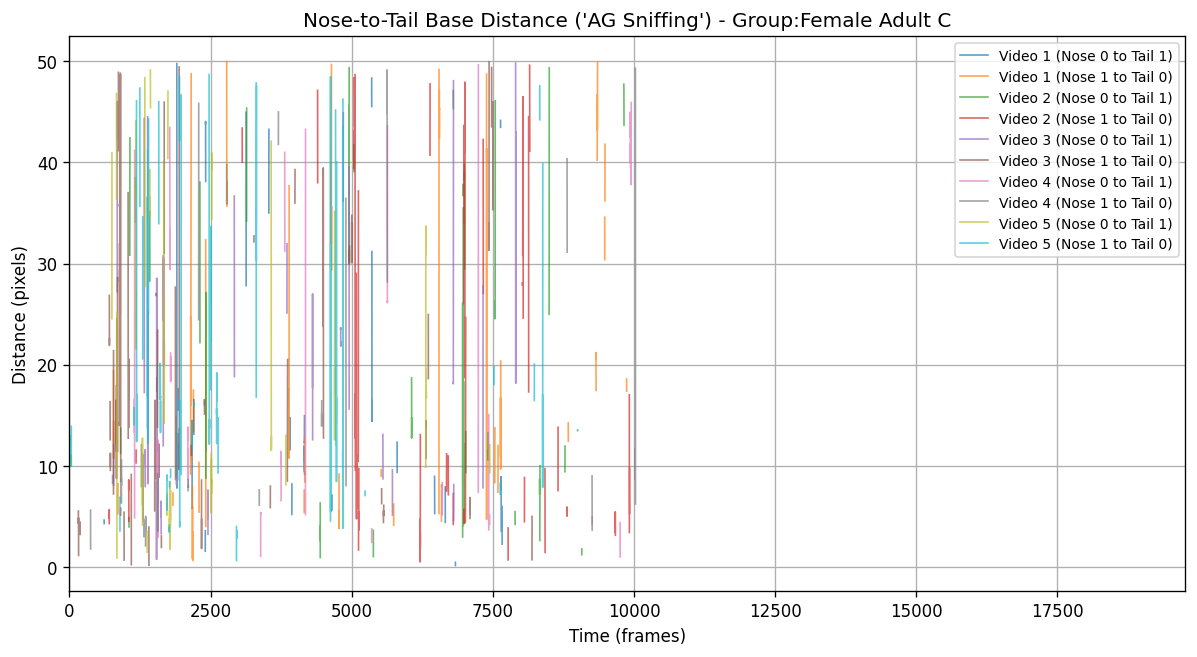

In [6]:
import glob
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt

# Specify the directory containing the .h5 files
folder_path = "/content/drive/MyDrive/Neuroscience/H5/Female adult C"

# Use glob to get all .h5 files in the specified folder
file_list = sorted(glob.glob(os.path.join(folder_path, "*.h5")))

# Initialize an empty dictionary to hold the sniffing data for each file
ag_sniffing_data = {}

# Define the threshold for AG sniffing (1 cm = 50 pixels)
threshold_pixels = 50

# Loop through each file and process
for idx, file_name in enumerate(file_list):
    with h5py.File(file_name, "r") as f:
        # Read and transpose the "tracks" dataset
        tracks = f["tracks"][:].transpose(3, 0, 2, 1)

        # Extract additional datasets and node names for the first file
        if idx == 0:
            node_names = [n.decode() for n in f["node_names"][:].tolist()]

        print(f"Processing {file_name}...")
        print("Available nodes:", node_names)

        # Get the indices for nose and tail
        nose_ind = node_names.index("nose")
        tail_ind = node_names.index("tail")

        # Extract coordinates for noses and tails
        noses = tracks[:, :, nose_ind]
        tails = tracks[:, :, tail_ind]

        # Compute the distances between noses and tails
        nose_to_tail = np.linalg.norm(
            np.expand_dims(noses, axis=2) - np.expand_dims(tails, axis=1), axis=-1
        )

        # Get total frames in the video
        total_frames = nose_to_tail.shape[0]

        # Extend x-axis but plot only for the first 10200 frames
        nose_to_tail_sniffing_0_1 = np.full(total_frames, np.nan)
        nose_to_tail_sniffing_1_0 = np.full(total_frames, np.nan)

        nose_to_tail_sniffing_0_1[:10200] = np.where(
            nose_to_tail[:10200, 0, 1] <= threshold_pixels, nose_to_tail[:10200, 0, 1], np.nan
        )
        nose_to_tail_sniffing_1_0[:10200] = np.where(
            nose_to_tail[:10200, 1, 0] <= threshold_pixels, nose_to_tail[:10200, 1, 0], np.nan
        )

        # Store the sniffing data for this file
        ag_sniffing_data[f"Video {idx + 1}"] = (nose_to_tail_sniffing_0_1, nose_to_tail_sniffing_1_0)

# Plot all the AG sniffing data on one graph
plt.figure(figsize=(12, 6), dpi=120)

# Plot each video's sniffing data
for video_name, (sniffing_0_1, sniffing_1_0) in ag_sniffing_data.items():
    # Generate x-values for the current video
    x_values = np.arange(len(sniffing_0_1))

    # Plot both directions of sniffing for this video
    plt.plot(x_values, sniffing_0_1, lw=1, alpha=0.7, label=f"{video_name} (Nose 0 to Tail 1)")
    plt.plot(x_values, sniffing_1_0, lw=1, alpha=0.7, label=f"{video_name} (Nose 1 to Tail 0)")


# Configure plot
plt.xlim(0, total_frames)  # Extend x-axis to the total number of frames
plt.xlabel("Time (frames)")
plt.ylabel("Distance (pixels)")
plt.title("Nose-to-Tail Base Distance ('AG Sniffing') - Group:Female Adult C")
plt.legend(loc="upper right", fontsize="small", ncol=1)
plt.grid(True)
plt.show()


Processing /content/drive/MyDrive/Neuroscience/H5/Female adult C/801.000_801 interaction.analysis.h5...
Available nodes: ['nose', 'left_ear', 'right_ear', 'neck', 'tail']
Processing /content/drive/MyDrive/Neuroscience/H5/Female adult C/842.000_842 interaction.analysis.h5...
Available nodes: ['nose', 'left_ear', 'right_ear', 'neck', 'tail']
Processing /content/drive/MyDrive/Neuroscience/H5/Female adult C/853.000_853 interaction.analysis.h5...
Available nodes: ['nose', 'left_ear', 'right_ear', 'neck', 'tail']
Processing /content/drive/MyDrive/Neuroscience/H5/Female adult C/857.000_857 interaction.analysis.h5...
Available nodes: ['nose', 'left_ear', 'right_ear', 'neck', 'tail']
Processing /content/drive/MyDrive/Neuroscience/H5/Female adult C/910.000_910 interaction.analysis.h5...
Available nodes: ['nose', 'left_ear', 'right_ear', 'neck', 'tail']


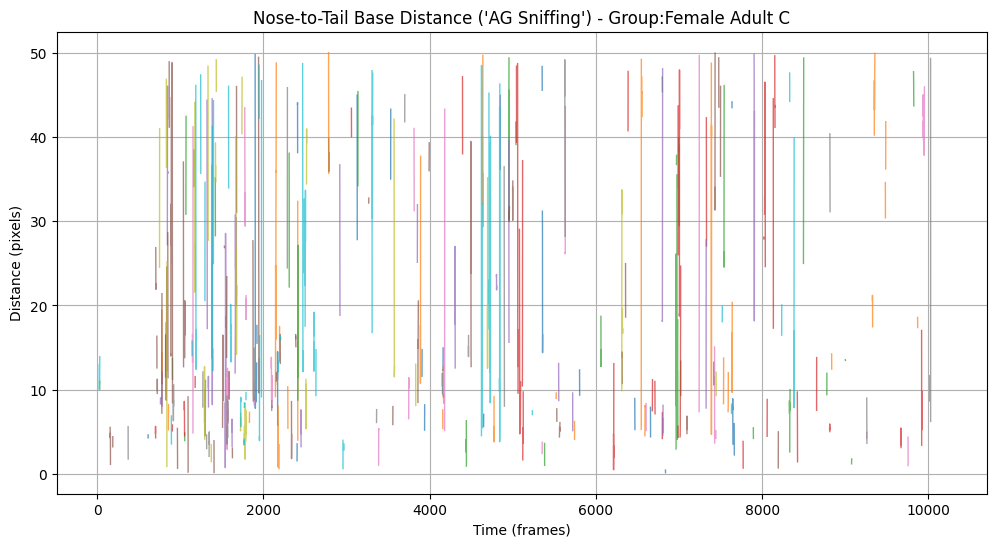

In [7]:
import glob
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt

# Specify the directory containing the .h5 files
folder_path = "/content/drive/MyDrive/Neuroscience/H5/Female adult C"

# Use glob to get all .h5 files in the specified folder
file_list = sorted(glob.glob(os.path.join(folder_path, "*.h5")))

# Initialize an empty dictionary to hold the sniffing data for each file
ag_sniffing_data = {}

# Define the threshold for AG sniffing (1 cm = 50 pixels)
threshold_pixels = 50

# Loop through each file and process
for idx, file_name in enumerate(file_list):
    with h5py.File(file_name, "r") as f:
        # Read and transpose the "tracks" dataset
        tracks = f["tracks"][:].transpose(3, 0, 2, 1)

        # Extract additional datasets and node names for the first file
        if idx == 0:
            node_names = [n.decode() for n in f["node_names"][:].tolist()]

        print(f"Processing {file_name}...")
        print("Available nodes:", node_names)

        # Get the indices for nose and tail
        nose_ind = node_names.index("nose")
        tail_ind = node_names.index("tail")

        # Extract coordinates for noses and tails
        noses = tracks[:, :, nose_ind]
        tails = tracks[:, :, tail_ind]

        # Compute the distances between noses and tails
        nose_to_tail = np.linalg.norm(
            np.expand_dims(noses, axis=2) - np.expand_dims(tails, axis=1), axis=-1
        )

        # Filter distances within the threshold for AG sniffing
        nose_to_tail_sniffing_0_1 = np.where(
            nose_to_tail[:10200, 0, 1] <= threshold_pixels, nose_to_tail[:10200, 0, 1], np.nan
        )
        nose_to_tail_sniffing_1_0 = np.where(
            nose_to_tail[:10200, 1, 0] <= threshold_pixels, nose_to_tail[:10200, 1, 0], np.nan
        )

        # Store the sniffing data for this file
        ag_sniffing_data[f"Video {idx + 1}"] = (nose_to_tail_sniffing_0_1, nose_to_tail_sniffing_1_0)

# Plot all the AG sniffing data on one graph
plt.figure(figsize=(12, 6), dpi=100)

# Plot each video's sniffing data
for video_name, (sniffing_0_1, sniffing_1_0) in ag_sniffing_data.items():
    # Generate x-values for the current video
    x_values = np.arange(len(sniffing_0_1))

    # Plot both directions of sniffing for this video
    plt.plot(x_values, sniffing_0_1, lw=1, alpha=0.7, label=f"{video_name} (Nose 0 to Tail 1)")
    plt.plot(x_values, sniffing_1_0, lw=1, alpha=0.7, label=f"{video_name} (Nose 1 to Tail 0)")


# Configure plot
plt.xlabel("Time (frames)")
plt.ylabel("Distance (pixels)")
plt.title("Nose-to-Tail Base Distance ('AG Sniffing') - Group:Female Adult C")
plt.grid(True)
plt.show()


Processing /content/drive/MyDrive/Neuroscience/H5/Female adult C/801.000_801 interaction.analysis.h5...
Available nodes: ['nose', 'left_ear', 'right_ear', 'neck', 'tail']
Processing /content/drive/MyDrive/Neuroscience/H5/Female adult C/842.000_842 interaction.analysis.h5...
Available nodes: ['nose', 'left_ear', 'right_ear', 'neck', 'tail']
Processing /content/drive/MyDrive/Neuroscience/H5/Female adult C/853.000_853 interaction.analysis.h5...
Available nodes: ['nose', 'left_ear', 'right_ear', 'neck', 'tail']
Processing /content/drive/MyDrive/Neuroscience/H5/Female adult C/857.000_857 interaction.analysis.h5...
Available nodes: ['nose', 'left_ear', 'right_ear', 'neck', 'tail']
Processing /content/drive/MyDrive/Neuroscience/H5/Female adult C/910.000_910 interaction.analysis.h5...
Available nodes: ['nose', 'left_ear', 'right_ear', 'neck', 'tail']


<ipython-input-8-ea1d37977b5d>:60: RuntimeWarning: Mean of empty slice
  sniffing_0_1_combined = np.nanmean([s[:min_frames] for s in sniffing_0_1_all], axis=0)
<ipython-input-8-ea1d37977b5d>:61: RuntimeWarning: Mean of empty slice
  sniffing_1_0_combined = np.nanmean([s[:min_frames] for s in sniffing_1_0_all], axis=0)


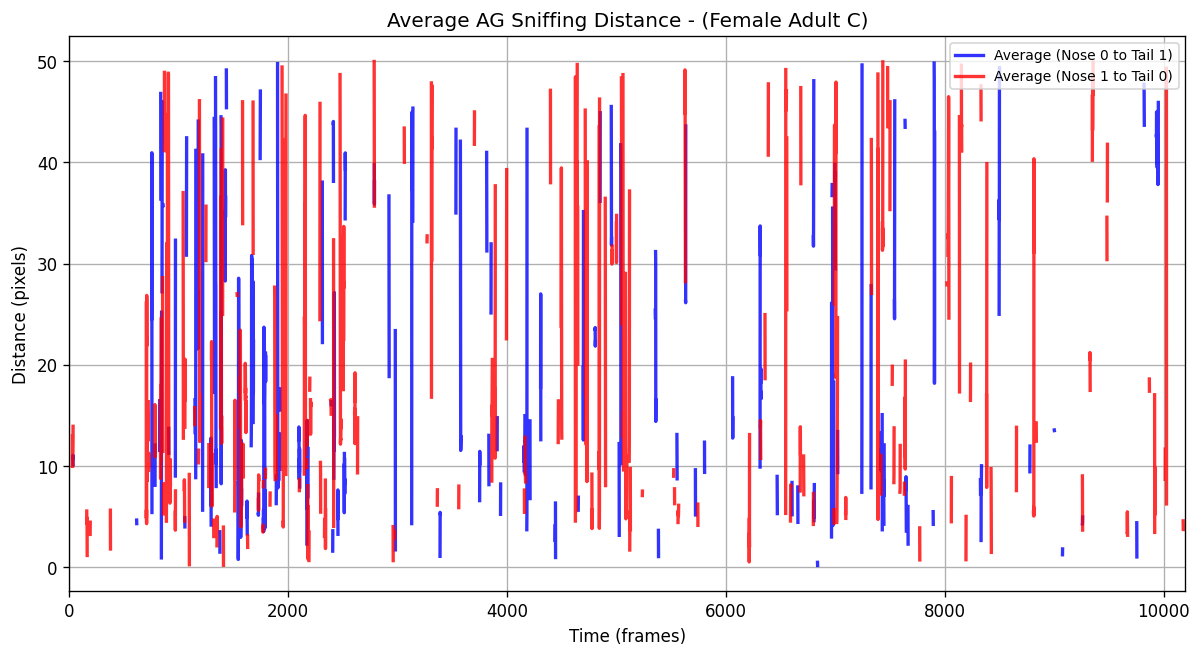

In [8]:
import glob
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt

# Specify the directory containing the .h5 files
folder_path = "/content/drive/MyDrive/Neuroscience/H5/Female adult C"

# Use glob to get all .h5 files in the specified folder
file_list = sorted(glob.glob(os.path.join(folder_path, "*.h5")))

# Initialize lists to hold sniffing data
sniffing_0_1_all = []
sniffing_1_0_all = []

# Define the threshold for AG sniffing (1 cm = 50 pixels)
threshold_pixels = 50

# Loop through each file and process
for idx, file_name in enumerate(file_list):
    with h5py.File(file_name, "r") as f:
        # Read and transpose the "tracks" dataset
        tracks = f["tracks"][:].transpose(3, 0, 2, 1)

        # Extract additional datasets and node names for the first file
        if idx == 0:
            node_names = [n.decode() for n in f["node_names"][:].tolist()]

        print(f"Processing {file_name}...")
        print("Available nodes:", node_names)

        # Get the indices for nose and tail
        nose_ind = node_names.index("nose")
        tail_ind = node_names.index("tail")

        # Extract coordinates for noses and tails
        noses = tracks[:, :, nose_ind]
        tails = tracks[:, :, tail_ind]

        # Compute the distances between noses and tails
        nose_to_tail = np.linalg.norm(
            np.expand_dims(noses, axis=2) - np.expand_dims(tails, axis=1), axis=-1
        )

        # Filter distances within the threshold for AG sniffing
        sniffing_0_1 = np.where(
            nose_to_tail[:10200, 0, 1] <= threshold_pixels, nose_to_tail[:10200, 0, 1], np.nan
        )
        sniffing_1_0 = np.where(
            nose_to_tail[:10200, 1, 0] <= threshold_pixels, nose_to_tail[:10200, 1, 0], np.nan
        )

        # Add data to the lists
        sniffing_0_1_all.append(sniffing_0_1)
        sniffing_1_0_all.append(sniffing_1_0)

# Combine data and compute average
min_frames = min(len(s) for s in sniffing_0_1_all)  # Align to the shortest video length
sniffing_0_1_combined = np.nanmean([s[:min_frames] for s in sniffing_0_1_all], axis=0)
sniffing_1_0_combined = np.nanmean([s[:min_frames] for s in sniffing_1_0_all], axis=0)

# Plot the average AG sniffing distance
plt.figure(figsize=(12, 6), dpi=120)

x_values = np.arange(min_frames)

plt.plot(x_values, sniffing_0_1_combined, lw=2, alpha=0.8, label="Average (Nose 0 to Tail 1)", color="blue")
plt.plot(x_values, sniffing_1_0_combined, lw=2, alpha=0.8, label="Average (Nose 1 to Tail 0)", color="red")

# Configure plot
plt.xlim(0, min_frames)  # Set x-axis limit to the aligned length
plt.xlabel("Time (frames)")
plt.ylabel("Distance (pixels)")
plt.title("Average AG Sniffing Distance - (Female Adult C)")
plt.legend(loc="upper right", fontsize="small", ncol=1)
plt.grid(True)
plt.show()


Processing /content/drive/MyDrive/Neuroscience/H5/Female adult C/801.000_801 interaction.analysis.h5...
Available nodes: ['nose', 'left_ear', 'right_ear', 'neck', 'tail']
Processing /content/drive/MyDrive/Neuroscience/H5/Female adult C/842.000_842 interaction.analysis.h5...
Available nodes: ['nose', 'left_ear', 'right_ear', 'neck', 'tail']
Processing /content/drive/MyDrive/Neuroscience/H5/Female adult C/853.000_853 interaction.analysis.h5...
Available nodes: ['nose', 'left_ear', 'right_ear', 'neck', 'tail']
Processing /content/drive/MyDrive/Neuroscience/H5/Female adult C/857.000_857 interaction.analysis.h5...
Available nodes: ['nose', 'left_ear', 'right_ear', 'neck', 'tail']
Processing /content/drive/MyDrive/Neuroscience/H5/Female adult C/910.000_910 interaction.analysis.h5...
Available nodes: ['nose', 'left_ear', 'right_ear', 'neck', 'tail']


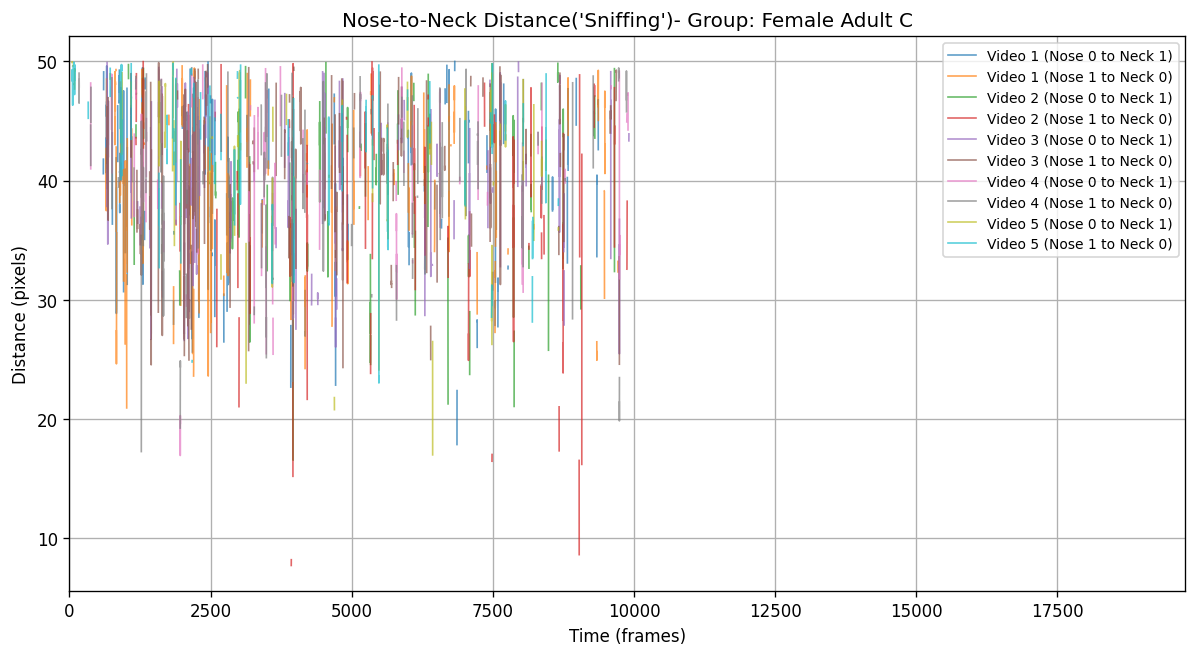

In [9]:
import glob
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt

# Specify the directory containing the .h5 files
folder_path = "/content/drive/MyDrive/Neuroscience/H5/Female adult C"

# Use glob to get all .h5 files in the specified folder
file_list = sorted(glob.glob(os.path.join(folder_path, "*.h5")))

# Initialize an empty dictionary to hold the sniffing data for each file
nose_to_neck_sniffing_data = {}

# Define the threshold for nose-to-neck sniffing (1 cm = 50 pixels)
threshold_pixels = 50

# Loop through each file and process
for idx, file_name in enumerate(file_list):
    with h5py.File(file_name, "r") as f:
        # Read and transpose the "tracks" dataset
        tracks = f["tracks"][:].transpose(3, 0, 2, 1)

        # Extract additional datasets and node names for the first file
        if idx == 0:
            node_names = [n.decode() for n in f["node_names"][:].tolist()]

        print(f"Processing {file_name}...")
        print("Available nodes:", node_names)

        # Get the indices for nose and neck
        nose_ind = node_names.index("nose")
        neck_ind = node_names.index("neck")

        # Extract coordinates for noses and necks
        noses = tracks[:, :, nose_ind]
        necks = tracks[:, :, neck_ind]

        # Compute the distances between noses and necks
        nose_to_neck = np.linalg.norm(
            np.expand_dims(noses, axis=2) - np.expand_dims(necks, axis=1), axis=-1
        )

        # Get total frames in the video
        total_frames = nose_to_neck.shape[0]

        # Extend x-axis but plot only for the first 10200 frames
        nose_to_neck_sniffing_0_1 = np.full(total_frames, np.nan)
        nose_to_neck_sniffing_1_0 = np.full(total_frames, np.nan)

        nose_to_neck_sniffing_0_1[:10200] = np.where(
            nose_to_neck[:10200, 0, 1] <= threshold_pixels, nose_to_neck[:10200, 0, 1], np.nan
        )
        nose_to_neck_sniffing_1_0[:10200] = np.where(
            nose_to_neck[:10200, 1, 0] <= threshold_pixels, nose_to_neck[:10200, 1, 0], np.nan
        )

        # Store the sniffing data for this file
        nose_to_neck_sniffing_data[f"Video {idx + 1}"] = (nose_to_neck_sniffing_0_1, nose_to_neck_sniffing_1_0)

# Plot all the nose-to-neck sniffing data on one graph
plt.figure(figsize=(12, 6), dpi=120)

# Plot each video's sniffing data
for video_name, (sniffing_0_1, sniffing_1_0) in nose_to_neck_sniffing_data.items():
    # Generate x-values for the current video
    x_values = np.arange(len(sniffing_0_1))

    # Plot both directions of sniffing for this video
    plt.plot(x_values, sniffing_0_1, lw=1, alpha=0.7, label=f"{video_name} (Nose 0 to Neck 1)")
    plt.plot(x_values, sniffing_1_0, lw=1, alpha=0.7, label=f"{video_name} (Nose 1 to Neck 0)")

# Configure plot
plt.xlim(0, total_frames)  # Extend x-axis to the total number of frames
plt.xlabel("Time (frames)")
plt.ylabel("Distance (pixels)")
plt.title("Nose-to-Neck Distance('Sniffing')- Group: Female Adult C")
plt.legend(loc="upper right", fontsize="small", ncol=1)
plt.grid(True)
plt.show()


Processing /content/drive/MyDrive/Neuroscience/H5/Female adult C/801.000_801 interaction.analysis.h5...
Available nodes: ['nose', 'left_ear', 'right_ear', 'neck', 'tail']
Processing /content/drive/MyDrive/Neuroscience/H5/Female adult C/842.000_842 interaction.analysis.h5...
Available nodes: ['nose', 'left_ear', 'right_ear', 'neck', 'tail']
Processing /content/drive/MyDrive/Neuroscience/H5/Female adult C/853.000_853 interaction.analysis.h5...
Available nodes: ['nose', 'left_ear', 'right_ear', 'neck', 'tail']
Processing /content/drive/MyDrive/Neuroscience/H5/Female adult C/857.000_857 interaction.analysis.h5...
Available nodes: ['nose', 'left_ear', 'right_ear', 'neck', 'tail']
Processing /content/drive/MyDrive/Neuroscience/H5/Female adult C/910.000_910 interaction.analysis.h5...
Available nodes: ['nose', 'left_ear', 'right_ear', 'neck', 'tail']


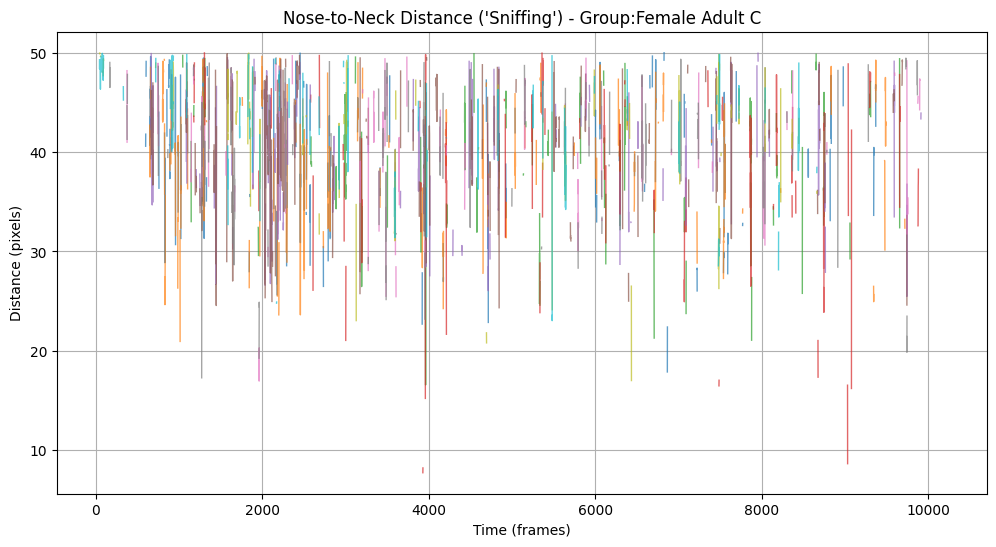

In [10]:
import glob
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt

# Specify the directory containing the .h5 files
folder_path = "/content/drive/MyDrive/Neuroscience/H5/Female adult C"

# Use glob to get all .h5 files in the specified folder
file_list = sorted(glob.glob(os.path.join(folder_path, "*.h5")))

# Initialize an empty dictionary to hold the sniffing data for each file
nose_to_neck_sniffing_data = {}

# Define the threshold for nose-to-neck sniffing (1 cm = 50 pixels)
threshold_pixels = 50

# Loop through each file and process
for idx, file_name in enumerate(file_list):
    with h5py.File(file_name, "r") as f:
        # Read and transpose the "tracks" dataset
        tracks = f["tracks"][:].transpose(3, 0, 2, 1)

        # Extract additional datasets and node names for the first file
        if idx == 0:
            node_names = [n.decode() for n in f["node_names"][:].tolist()]

        print(f"Processing {file_name}...")
        print("Available nodes:", node_names)

        # Get the indices for nose and neck
        nose_ind = node_names.index("nose")
        neck_ind = node_names.index("neck")

        # Extract coordinates for noses and necks
        noses = tracks[:, :, nose_ind]
        necks = tracks[:, :, neck_ind]

        # Compute the distances between noses and necks
        nose_to_neck = np.linalg.norm(
            np.expand_dims(noses, axis=2) - np.expand_dims(necks, axis=1), axis=-1
        )

        # Filter distances within the threshold for nose-to-neck sniffing
        nose_to_neck_sniffing_0_1 = np.where(
            nose_to_neck[:10200, 0, 1] <= threshold_pixels, nose_to_neck[:10200, 0, 1], np.nan
        )
        nose_to_neck_sniffing_1_0 = np.where(
            nose_to_neck[:10200, 1, 0] <= threshold_pixels, nose_to_neck[:10200, 1, 0], np.nan
        )

        # Store the sniffing data for this file
        nose_to_neck_sniffing_data[f"Video {idx + 1}"] = (nose_to_neck_sniffing_0_1, nose_to_neck_sniffing_1_0)

# Plot all the nose-to-neck sniffing data on one graph
plt.figure(figsize=(12, 6), dpi=100)

# Plot each video's sniffing data
for video_name, (sniffing_0_1, sniffing_1_0) in nose_to_neck_sniffing_data.items():
    # Generate x-values for the current video
    x_values = np.arange(len(sniffing_0_1))

    # Plot both directions of sniffing for this video
    plt.plot(x_values, sniffing_0_1, lw=1, alpha=0.7, label=f"{video_name} (Nose 0 to Neck 1)")
    plt.plot(x_values, sniffing_1_0, lw=1, alpha=0.7, label=f"{video_name} (Nose 1 to Neck 0)")


# Configure plot
plt.xlabel("Time (frames)")
plt.ylabel("Distance (pixels)")
plt.title("Nose-to-Neck Distance ('Sniffing') - Group:Female Adult C")

plt.grid(True)
plt.show()


Processing /content/drive/MyDrive/Neuroscience/H5/Female adult C/801.000_801 interaction.analysis.h5...
Available nodes: ['nose', 'left_ear', 'right_ear', 'neck', 'tail']
Processing /content/drive/MyDrive/Neuroscience/H5/Female adult C/842.000_842 interaction.analysis.h5...
Available nodes: ['nose', 'left_ear', 'right_ear', 'neck', 'tail']
Processing /content/drive/MyDrive/Neuroscience/H5/Female adult C/853.000_853 interaction.analysis.h5...
Available nodes: ['nose', 'left_ear', 'right_ear', 'neck', 'tail']
Processing /content/drive/MyDrive/Neuroscience/H5/Female adult C/857.000_857 interaction.analysis.h5...
Available nodes: ['nose', 'left_ear', 'right_ear', 'neck', 'tail']
Processing /content/drive/MyDrive/Neuroscience/H5/Female adult C/910.000_910 interaction.analysis.h5...
Available nodes: ['nose', 'left_ear', 'right_ear', 'neck', 'tail']


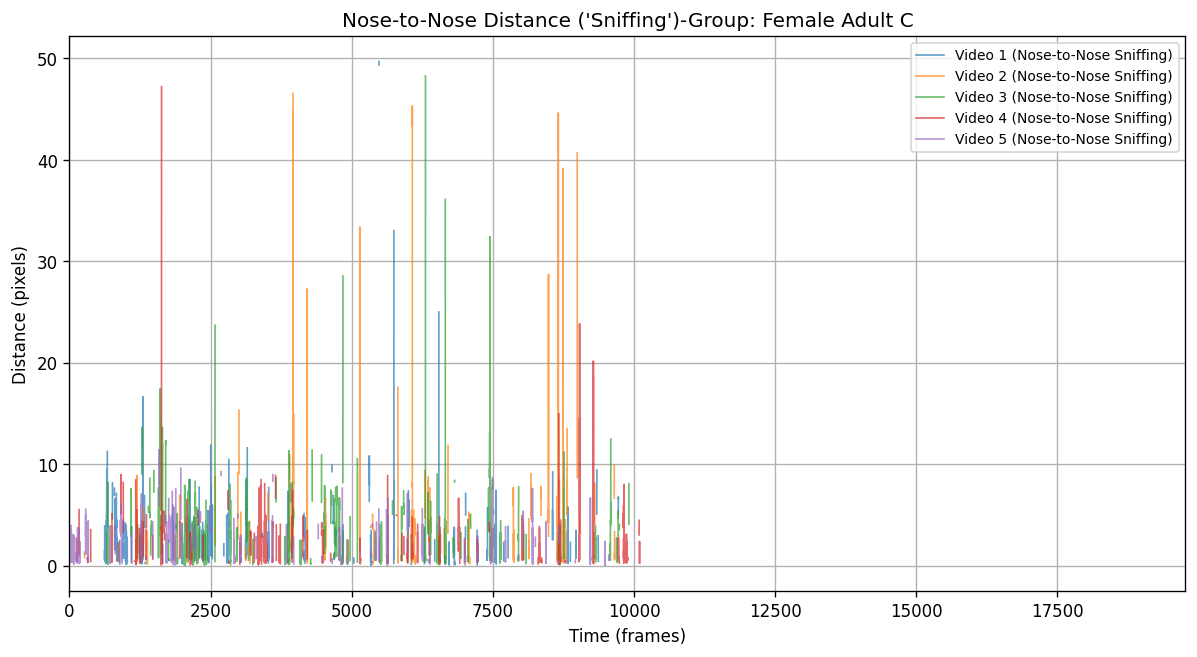

In [11]:
import glob
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt

# Specify the directory containing the .h5 files
folder_path = "/content/drive/MyDrive/Neuroscience/H5/Female adult C"

# Use glob to get all .h5 files in the specified folder
file_list = sorted(glob.glob(os.path.join(folder_path, "*.h5")))

# Initialize an empty dictionary to hold the sniffing data for each file
nose_to_nose_sniffing_data = {}

# Define the threshold for nose-to-nose sniffing (1 cm = 50 pixels)
threshold_pixels = 50

# Loop through each file and process
for idx, file_name in enumerate(file_list):
    with h5py.File(file_name, "r") as f:
        # Read and transpose the "tracks" dataset
        tracks = f["tracks"][:].transpose(3, 0, 2, 1)

        # Extract additional datasets and node names for the first file
        if idx == 0:
            node_names = [n.decode() for n in f["node_names"][:].tolist()]

        print(f"Processing {file_name}...")
        print("Available nodes:", node_names)

        # Get the indices for nose
        nose_ind = node_names.index("nose")

        # Extract coordinates for noses
        noses = tracks[:, :, nose_ind]

        # Compute the distances between noses
        nose_to_nose = np.linalg.norm(
            np.expand_dims(noses, axis=2) - np.expand_dims(noses, axis=1), axis=-1
        )

        # Get total frames in the video
        total_frames = nose_to_nose.shape[0]

        # Extend x-axis but plot only for the first 10200 frames
        nose_to_nose_sniffing = np.full(total_frames, np.nan)

        nose_to_nose_sniffing[:10200] = np.where(
            nose_to_nose[:10200, 0, 1] <= threshold_pixels, nose_to_nose[:10200, 0, 1], np.nan
        )

        # Store the sniffing data for this file
        nose_to_nose_sniffing_data[f"Video {idx + 1}"] = nose_to_nose_sniffing

# Plot all the nose-to-nose sniffing data on one graph
plt.figure(figsize=(12, 6), dpi=120)

# Plot each video's sniffing data
for video_name, sniffing in nose_to_nose_sniffing_data.items():
    # Generate x-values for the current video
    x_values = np.arange(len(sniffing))

    # Plot sniffing data for this video
    plt.plot(x_values, sniffing, lw=1, alpha=0.7, label=f"{video_name} (Nose-to-Nose Sniffing)")

# Configure plot
plt.xlim(0, total_frames)  # Extend x-axis to the total number of frames
plt.xlabel("Time (frames)")
plt.ylabel("Distance (pixels)")
plt.title("Nose-to-Nose Distance ('Sniffing')-Group: Female Adult C")
plt.legend(loc="upper right", fontsize="small", ncol=1)
plt.grid(True)
plt.show()


Processing /content/drive/MyDrive/Neuroscience/H5/Female adult C/801.000_801 interaction.analysis.h5...
Available nodes: ['nose', 'left_ear', 'right_ear', 'neck', 'tail']
Processing /content/drive/MyDrive/Neuroscience/H5/Female adult C/842.000_842 interaction.analysis.h5...
Available nodes: ['nose', 'left_ear', 'right_ear', 'neck', 'tail']
Processing /content/drive/MyDrive/Neuroscience/H5/Female adult C/853.000_853 interaction.analysis.h5...
Available nodes: ['nose', 'left_ear', 'right_ear', 'neck', 'tail']
Processing /content/drive/MyDrive/Neuroscience/H5/Female adult C/857.000_857 interaction.analysis.h5...
Available nodes: ['nose', 'left_ear', 'right_ear', 'neck', 'tail']
Processing /content/drive/MyDrive/Neuroscience/H5/Female adult C/910.000_910 interaction.analysis.h5...
Available nodes: ['nose', 'left_ear', 'right_ear', 'neck', 'tail']


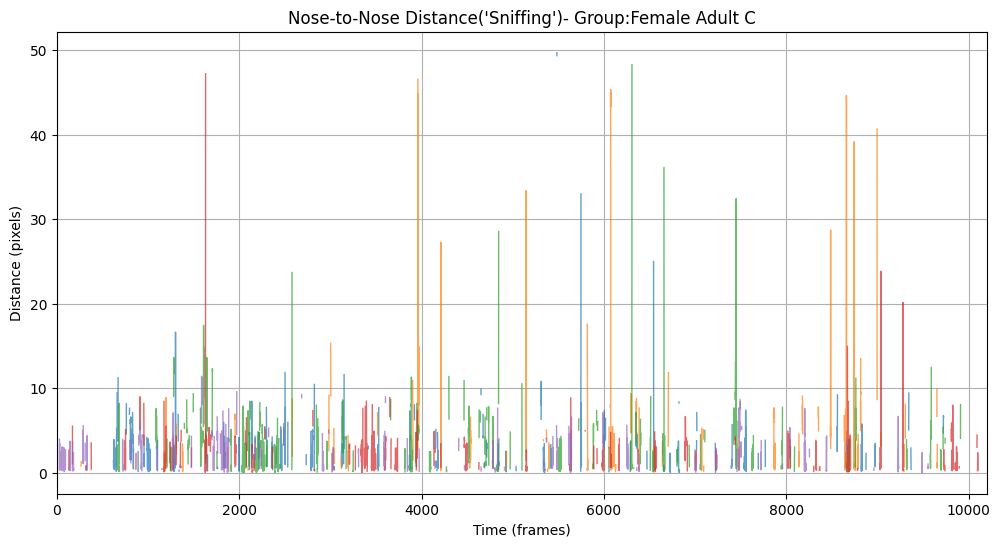

In [12]:
import glob
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt

# Specify the directory containing the .h5 files
folder_path = "/content/drive/MyDrive/Neuroscience/H5/Female adult C"

# Use glob to get all .h5 files in the specified folder
file_list = sorted(glob.glob(os.path.join(folder_path, "*.h5")))

# Initialize an empty dictionary to hold the sniffing data for each file
nose_to_nose_sniffing_data = {}

# Define the threshold for nose-to-nose sniffing (1 cm = 50 pixels)
threshold_pixels = 50

# Loop through each file and process
for idx, file_name in enumerate(file_list):
    with h5py.File(file_name, "r") as f:
        # Read and transpose the "tracks" dataset
        tracks = f["tracks"][:].transpose(3, 0, 2, 1)

        # Extract additional datasets and node names for the first file
        if idx == 0:
            node_names = [n.decode() for n in f["node_names"][:].tolist()]

        print(f"Processing {file_name}...")
        print("Available nodes:", node_names)

        # Get the indices for nose
        nose_ind = node_names.index("nose")

        # Extract coordinates for noses
        noses = tracks[:, :, nose_ind]

        # Compute the distances between noses
        nose_to_nose = np.linalg.norm(
            np.expand_dims(noses, axis=2) - np.expand_dims(noses, axis=1), axis=-1
        )

        # Filter distances within the threshold for nose-to-nose sniffing
        nose_to_nose_sniffing = np.where(
            nose_to_nose[:10200, 0, 1] <= threshold_pixels, nose_to_nose[:10200, 0, 1], np.nan
        )

        # Store the sniffing data for this file
        nose_to_nose_sniffing_data[f"Video {idx + 1}"] = nose_to_nose_sniffing

# Plot all the nose-to-nose sniffing data on one graph
plt.figure(figsize=(12, 6), dpi=100)

# Plot each video's sniffing data
for video_name, sniffing in nose_to_nose_sniffing_data.items():
    # Generate x-values for the current video
    x_values = np.arange(len(sniffing))

    # Plot sniffing data for this video
    plt.plot(x_values, sniffing, lw=1, alpha=0.7, label=f"{video_name} (Nose-to-Nose Sniffing)")

# Configure plot
plt.xlim(0, 10200)  # Set x-axis limit to match the sniffing frame limit
plt.xlabel("Time (frames)")
plt.ylabel("Distance (pixels)")
plt.title("Nose-to-Nose Distance('Sniffing')- Group:Female Adult C")
plt.grid(True)
plt.show()


Processing /content/drive/MyDrive/Neuroscience/H5/Female adult C/801.000_801 interaction.analysis.h5...
Available nodes: ['nose', 'left_ear', 'right_ear', 'neck', 'tail']
Processing /content/drive/MyDrive/Neuroscience/H5/Female adult C/842.000_842 interaction.analysis.h5...
Available nodes: ['nose', 'left_ear', 'right_ear', 'neck', 'tail']
Processing /content/drive/MyDrive/Neuroscience/H5/Female adult C/853.000_853 interaction.analysis.h5...
Available nodes: ['nose', 'left_ear', 'right_ear', 'neck', 'tail']
Processing /content/drive/MyDrive/Neuroscience/H5/Female adult C/857.000_857 interaction.analysis.h5...
Available nodes: ['nose', 'left_ear', 'right_ear', 'neck', 'tail']
Processing /content/drive/MyDrive/Neuroscience/H5/Female adult C/910.000_910 interaction.analysis.h5...
Available nodes: ['nose', 'left_ear', 'right_ear', 'neck', 'tail']


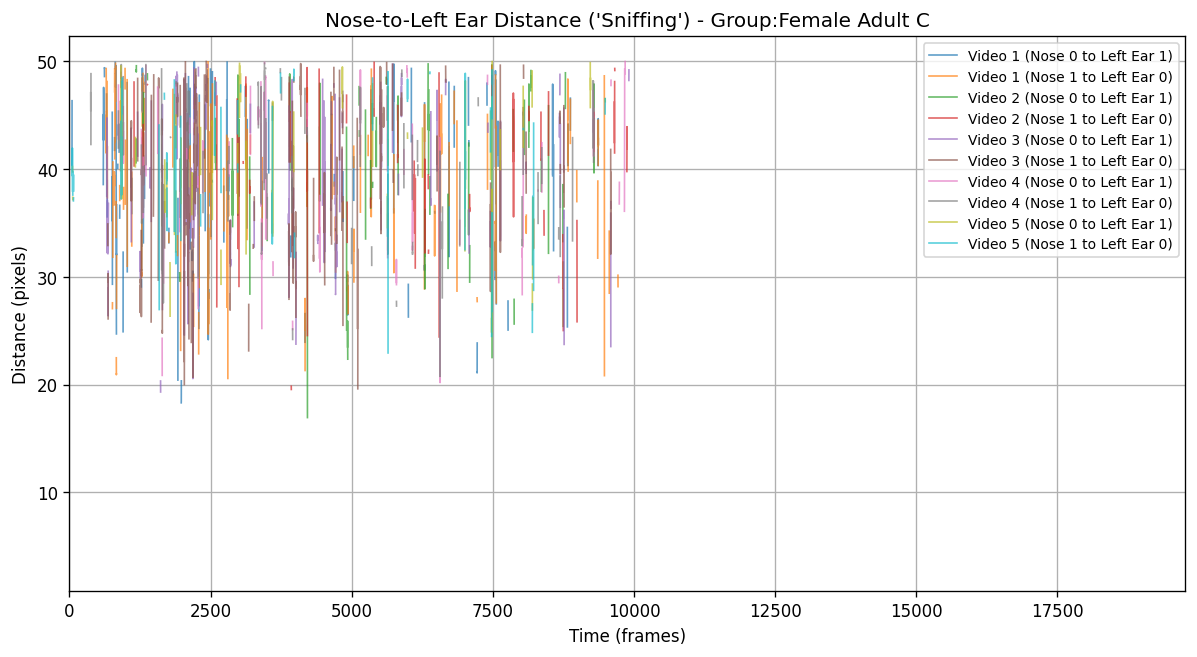

In [ ]:
import glob
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt

# Specify the directory containing the .h5 files
folder_path = "/content/drive/MyDrive/Neuroscience/H5/Female adult C"

# Use glob to get all .h5 files in the specified folder
file_list = sorted(glob.glob(os.path.join(folder_path, "*.h5")))

# Initialize an empty dictionary to hold the sniffing data for each file
nose_to_left_ear_sniffing_data = {}

# Define the threshold for nose-to-left ear sniffing (1 cm = 50 pixels)
threshold_pixels = 50

# Loop through each file and process
for idx, file_name in enumerate(file_list):
    with h5py.File(file_name, "r") as f:
        # Read and transpose the "tracks" dataset
        tracks = f["tracks"][:].transpose(3, 0, 2, 1)

        # Extract additional datasets and node names for the first file
        if idx == 0:
            node_names = [n.decode() for n in f["node_names"][:].tolist()]

        print(f"Processing {file_name}...")
        print("Available nodes:", node_names)

        # Get the indices for nose and left ear
        nose_ind = node_names.index("nose")
        left_ear_ind = node_names.index("left_ear")

        # Extract coordinates for noses and left ears
        noses = tracks[:, :, nose_ind]
        left_ears = tracks[:, :, left_ear_ind]

        # Compute the distances between noses and left ears
        nose_to_left_ear = np.linalg.norm(
            np.expand_dims(noses, axis=2) - np.expand_dims(left_ears, axis=1), axis=-1
        )

        # Get total frames in the video
        total_frames = nose_to_left_ear.shape[0]

        # Extend x-axis but plot only for the first 10200 frames
        nose_to_left_ear_sniffing_0_1 = np.full(total_frames, np.nan)
        nose_to_left_ear_sniffing_1_0 = np.full(total_frames, np.nan)

        nose_to_left_ear_sniffing_0_1[:10200] = np.where(
            nose_to_left_ear[:10200, 0, 1] <= threshold_pixels, nose_to_left_ear[:10200, 0, 1], np.nan
        )
        nose_to_left_ear_sniffing_1_0[:10200] = np.where(
            nose_to_left_ear[:10200, 1, 0] <= threshold_pixels, nose_to_left_ear[:10200, 1, 0], np.nan
        )

        # Store the sniffing data for this file
        nose_to_left_ear_sniffing_data[f"Video {idx + 1}"] = (nose_to_left_ear_sniffing_0_1, nose_to_left_ear_sniffing_1_0)

# Plot all the nose-to-left ear sniffing data on one graph
plt.figure(figsize=(12, 6), dpi=120)

# Plot each video's sniffing data
for video_name, (sniffing_0_1, sniffing_1_0) in nose_to_left_ear_sniffing_data.items():
    # Generate x-values for the current video
    x_values = np.arange(len(sniffing_0_1))

    # Plot both directions of sniffing for this video
    plt.plot(x_values, sniffing_0_1, lw=1, alpha=0.7, label=f"{video_name} (Nose 0 to Left Ear 1)")
    plt.plot(x_values, sniffing_1_0, lw=1, alpha=0.7, label=f"{video_name} (Nose 1 to Left Ear 0)")

# Configure plot
plt.xlim(0, total_frames)  # Extend x-axis to the total number of frames
plt.xlabel("Time (frames)")
plt.ylabel("Distance (pixels)")
plt.title("Nose-to-Left Ear Distance ('Sniffing') - Group:Female Adult C")
plt.legend(loc="upper right", fontsize="small", ncol=1)
plt.grid(True)
plt.show()


Processing /content/drive/MyDrive/Neuroscience/H5/Female adult C/801.000_801 interaction.analysis.h5...
Available nodes: ['nose', 'left_ear', 'right_ear', 'neck', 'tail']
Processing /content/drive/MyDrive/Neuroscience/H5/Female adult C/842.000_842 interaction.analysis.h5...
Available nodes: ['nose', 'left_ear', 'right_ear', 'neck', 'tail']
Processing /content/drive/MyDrive/Neuroscience/H5/Female adult C/853.000_853 interaction.analysis.h5...
Available nodes: ['nose', 'left_ear', 'right_ear', 'neck', 'tail']
Processing /content/drive/MyDrive/Neuroscience/H5/Female adult C/857.000_857 interaction.analysis.h5...
Available nodes: ['nose', 'left_ear', 'right_ear', 'neck', 'tail']
Processing /content/drive/MyDrive/Neuroscience/H5/Female adult C/910.000_910 interaction.analysis.h5...
Available nodes: ['nose', 'left_ear', 'right_ear', 'neck', 'tail']


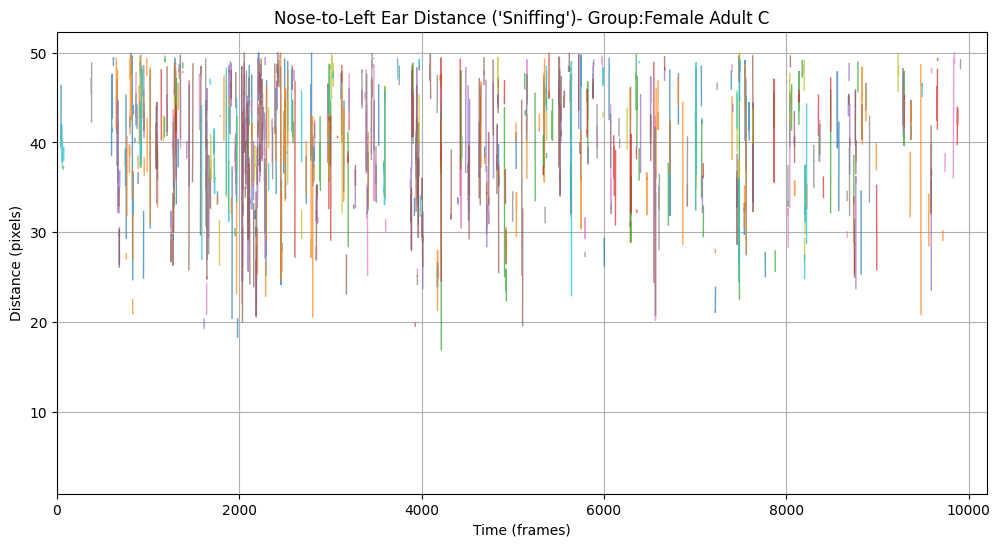

In [ ]:
import glob
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt

# Specify the directory containing the .h5 files
folder_path = "/content/drive/MyDrive/Neuroscience/H5/Female adult C"

# Use glob to get all .h5 files in the specified folder
file_list = sorted(glob.glob(os.path.join(folder_path, "*.h5")))

# Initialize an empty dictionary to hold the sniffing data for each file
nose_to_left_ear_sniffing_data = {}

# Define the threshold for nose-to-left ear sniffing (1 cm = 50 pixels)
threshold_pixels = 50

# Loop through each file and process
for idx, file_name in enumerate(file_list):
    with h5py.File(file_name, "r") as f:
        # Read and transpose the "tracks" dataset
        tracks = f["tracks"][:].transpose(3, 0, 2, 1)

        # Extract additional datasets and node names for the first file
        if idx == 0:
            node_names = [n.decode() for n in f["node_names"][:].tolist()]

        print(f"Processing {file_name}...")
        print("Available nodes:", node_names)

        # Get the indices for nose and left ear
        nose_ind = node_names.index("nose")
        left_ear_ind = node_names.index("left_ear")

        # Extract coordinates for noses and left ears
        noses = tracks[:, :, nose_ind]
        left_ears = tracks[:, :, left_ear_ind]

        # Compute the distances between noses and left ears
        nose_to_left_ear = np.linalg.norm(
            np.expand_dims(noses, axis=2) - np.expand_dims(left_ears, axis=1), axis=-1
        )

        # Filter distances within the threshold for nose-to-left ear sniffing
        nose_to_left_ear_sniffing_0_1 = np.where(
            nose_to_left_ear[:10200, 0, 1] <= threshold_pixels, nose_to_left_ear[:10200, 0, 1], np.nan
        )
        nose_to_left_ear_sniffing_1_0 = np.where(
            nose_to_left_ear[:10200, 1, 0] <= threshold_pixels, nose_to_left_ear[:10200, 1, 0], np.nan
        )

        # Store the sniffing data for this file
        nose_to_left_ear_sniffing_data[f"Video {idx + 1}"] = (nose_to_left_ear_sniffing_0_1, nose_to_left_ear_sniffing_1_0)

# Plot all the nose-to-left ear sniffing data on one graph
plt.figure(figsize=(12, 6), dpi=100)

# Plot each video's sniffing data
for video_name, (sniffing_0_1, sniffing_1_0) in nose_to_left_ear_sniffing_data.items():
    # Generate x-values for the current video
    x_values = np.arange(len(sniffing_0_1))

    # Plot both directions of sniffing for this video
    plt.plot(x_values, sniffing_0_1, lw=1, alpha=0.7, label=f"{video_name} (Nose 0 to Left Ear 1)")
    plt.plot(x_values, sniffing_1_0, lw=1, alpha=0.7, label=f"{video_name} (Nose 1 to Left Ear 0)")


# Configure plot
plt.xlim(0, 10200)  # Set x-axis limit to match the sniffing frame limit
plt.xlabel("Time (frames)")
plt.ylabel("Distance (pixels)")
plt.title("Nose-to-Left Ear Distance ('Sniffing')- Group:Female Adult C")

plt.grid(True)
plt.show()


Processing /content/drive/MyDrive/Neuroscience/H5/Female adult C/801.000_801 interaction.analysis.h5...
Available nodes: ['nose', 'left_ear', 'right_ear', 'neck', 'tail']
Processing /content/drive/MyDrive/Neuroscience/H5/Female adult C/842.000_842 interaction.analysis.h5...
Available nodes: ['nose', 'left_ear', 'right_ear', 'neck', 'tail']
Processing /content/drive/MyDrive/Neuroscience/H5/Female adult C/853.000_853 interaction.analysis.h5...
Available nodes: ['nose', 'left_ear', 'right_ear', 'neck', 'tail']
Processing /content/drive/MyDrive/Neuroscience/H5/Female adult C/857.000_857 interaction.analysis.h5...
Available nodes: ['nose', 'left_ear', 'right_ear', 'neck', 'tail']
Processing /content/drive/MyDrive/Neuroscience/H5/Female adult C/910.000_910 interaction.analysis.h5...
Available nodes: ['nose', 'left_ear', 'right_ear', 'neck', 'tail']


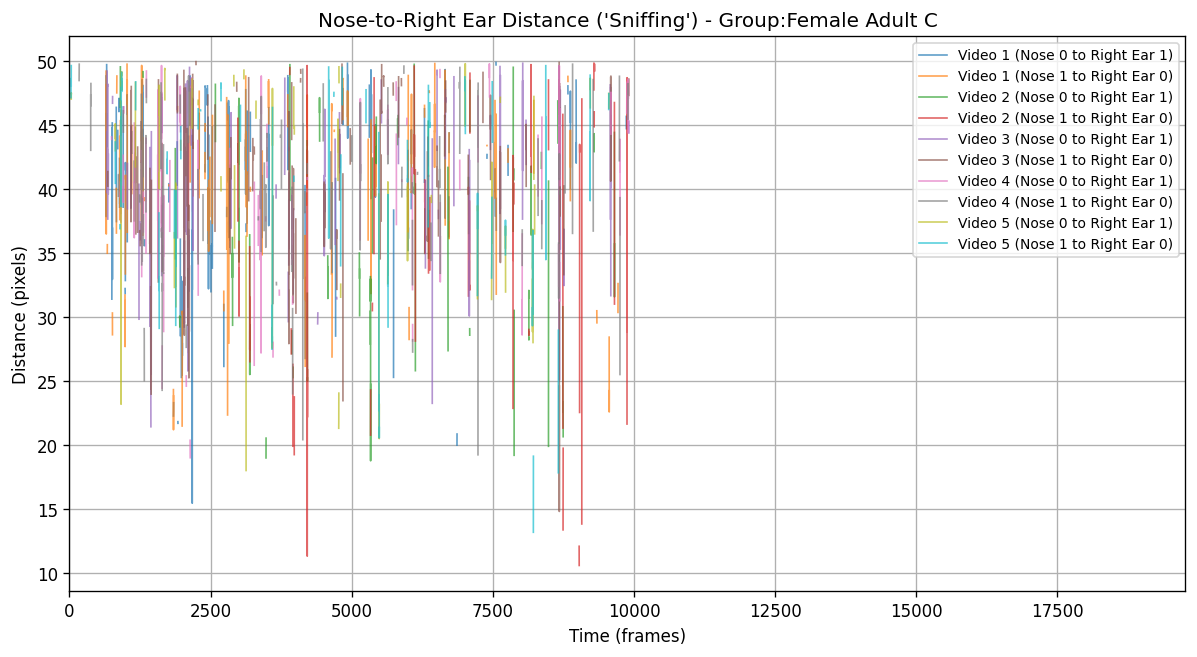

In [ ]:
import glob
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt

# Specify the directory containing the .h5 files
folder_path = "/content/drive/MyDrive/Neuroscience/H5/Female adult C"

# Use glob to get all .h5 files in the specified folder
file_list = sorted(glob.glob(os.path.join(folder_path, "*.h5")))

# Initialize an empty dictionary to hold the sniffing data for each file
nose_to_right_ear_sniffing_data = {}

# Define the threshold for nose-to-right ear sniffing (1 cm = 50 pixels)
threshold_pixels = 50

# Loop through each file and process
for idx, file_name in enumerate(file_list):
    with h5py.File(file_name, "r") as f:
        # Read and transpose the "tracks" dataset
        tracks = f["tracks"][:].transpose(3, 0, 2, 1)

        # Extract additional datasets and node names for the first file
        if idx == 0:
            node_names = [n.decode() for n in f["node_names"][:].tolist()]

        print(f"Processing {file_name}...")
        print("Available nodes:", node_names)

        # Get the indices for nose and right ear
        nose_ind = node_names.index("nose")
        right_ear_ind = node_names.index("right_ear")

        # Extract coordinates for noses and right ears
        noses = tracks[:, :, nose_ind]
        right_ears = tracks[:, :, right_ear_ind]

        # Compute the distances between noses and right ears
        nose_to_right_ear = np.linalg.norm(
            np.expand_dims(noses, axis=2) - np.expand_dims(right_ears, axis=1), axis=-1
        )

        # Get total frames in the video
        total_frames = nose_to_right_ear.shape[0]

        # Extend x-axis but plot only for the first 10200 frames
        nose_to_right_ear_sniffing_0_1 = np.full(total_frames, np.nan)
        nose_to_right_ear_sniffing_1_0 = np.full(total_frames, np.nan)

        nose_to_right_ear_sniffing_0_1[:10200] = np.where(
            nose_to_right_ear[:10200, 0, 1] <= threshold_pixels, nose_to_right_ear[:10200, 0, 1], np.nan
        )
        nose_to_right_ear_sniffing_1_0[:10200] = np.where(
            nose_to_right_ear[:10200, 1, 0] <= threshold_pixels, nose_to_right_ear[:10200, 1, 0], np.nan
        )

        # Store the sniffing data for this file
        nose_to_right_ear_sniffing_data[f"Video {idx + 1}"] = (nose_to_right_ear_sniffing_0_1, nose_to_right_ear_sniffing_1_0)

# Plot all the nose-to-right ear sniffing data on one graph
plt.figure(figsize=(12, 6), dpi=120)

# Plot each video's sniffing data
for video_name, (sniffing_0_1, sniffing_1_0) in nose_to_right_ear_sniffing_data.items():
    # Generate x-values for the current video
    x_values = np.arange(len(sniffing_0_1))

    # Plot both directions of sniffing for this video
    plt.plot(x_values, sniffing_0_1, lw=1, alpha=0.7, label=f"{video_name} (Nose 0 to Right Ear 1)")
    plt.plot(x_values, sniffing_1_0, lw=1, alpha=0.7, label=f"{video_name} (Nose 1 to Right Ear 0)")

# Configure plot
plt.xlim(0, total_frames)  # Extend x-axis to the total number of frames
plt.xlabel("Time (frames)")
plt.ylabel("Distance (pixels)")
plt.title("Nose-to-Right Ear Distance ('Sniffing') - Group:Female Adult C")
plt.legend(loc="upper right", fontsize="small", ncol=1)
plt.grid(True)
plt.show()


Processing /content/drive/MyDrive/Neuroscience/H5/Female adult C/801.000_801 interaction.analysis.h5...
Available nodes: ['nose', 'left_ear', 'right_ear', 'neck', 'tail']
Processing /content/drive/MyDrive/Neuroscience/H5/Female adult C/842.000_842 interaction.analysis.h5...
Available nodes: ['nose', 'left_ear', 'right_ear', 'neck', 'tail']
Processing /content/drive/MyDrive/Neuroscience/H5/Female adult C/853.000_853 interaction.analysis.h5...
Available nodes: ['nose', 'left_ear', 'right_ear', 'neck', 'tail']
Processing /content/drive/MyDrive/Neuroscience/H5/Female adult C/857.000_857 interaction.analysis.h5...
Available nodes: ['nose', 'left_ear', 'right_ear', 'neck', 'tail']
Processing /content/drive/MyDrive/Neuroscience/H5/Female adult C/910.000_910 interaction.analysis.h5...
Available nodes: ['nose', 'left_ear', 'right_ear', 'neck', 'tail']


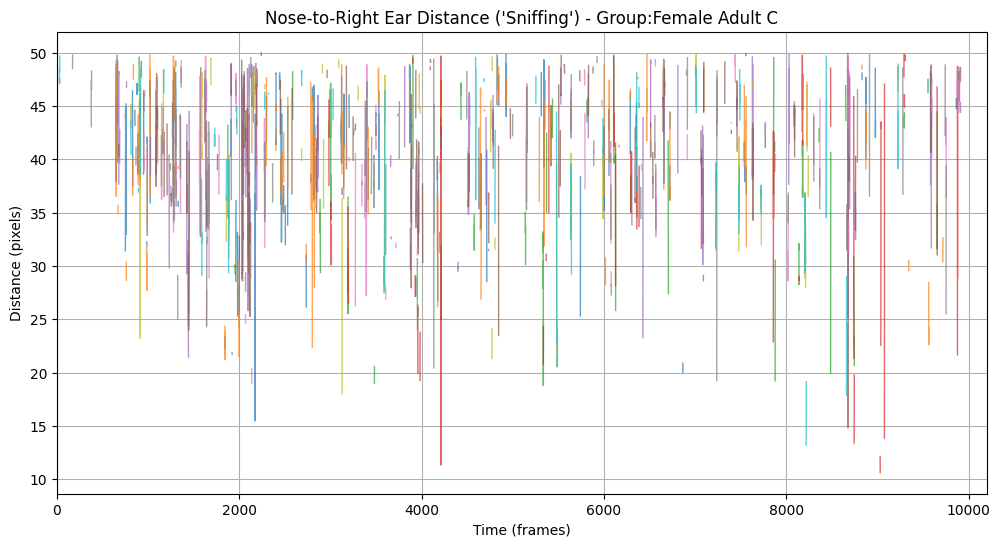

In [ ]:
import glob
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt

# Specify the directory containing the .h5 files
folder_path = "/content/drive/MyDrive/Neuroscience/H5/Female adult C"

# Use glob to get all .h5 files in the specified folder
file_list = sorted(glob.glob(os.path.join(folder_path, "*.h5")))

# Initialize an empty dictionary to hold the sniffing data for each file
nose_to_right_ear_sniffing_data = {}

# Define the threshold for nose-to-right ear sniffing (1 cm = 50 pixels)
threshold_pixels = 50

# Loop through each file and process
for idx, file_name in enumerate(file_list):
    with h5py.File(file_name, "r") as f:
        # Read and transpose the "tracks" dataset
        tracks = f["tracks"][:].transpose(3, 0, 2, 1)

        # Extract additional datasets and node names for the first file
        if idx == 0:
            node_names = [n.decode() for n in f["node_names"][:].tolist()]

        print(f"Processing {file_name}...")
        print("Available nodes:", node_names)

        # Get the indices for nose and right ear
        nose_ind = node_names.index("nose")
        right_ear_ind = node_names.index("right_ear")

        # Extract coordinates for noses and right ears
        noses = tracks[:, :, nose_ind]
        right_ears = tracks[:, :, right_ear_ind]

        # Compute the distances between noses and right ears
        nose_to_right_ear = np.linalg.norm(
            np.expand_dims(noses, axis=2) - np.expand_dims(right_ears, axis=1), axis=-1
        )

        # Filter distances within the threshold for nose-to-right ear sniffing
        nose_to_right_ear_sniffing_0_1 = np.where(
            nose_to_right_ear[:10200, 0, 1] <= threshold_pixels, nose_to_right_ear[:10200, 0, 1], np.nan
        )
        nose_to_right_ear_sniffing_1_0 = np.where(
            nose_to_right_ear[:10200, 1, 0] <= threshold_pixels, nose_to_right_ear[:10200, 1, 0], np.nan
        )

        # Store the sniffing data for this file
        nose_to_right_ear_sniffing_data[f"Video {idx + 1}"] = (nose_to_right_ear_sniffing_0_1, nose_to_right_ear_sniffing_1_0)

# Plot all the nose-to-right ear sniffing data on one graph
plt.figure(figsize=(12, 6), dpi=100)

# Plot each video's sniffing data
for video_name, (sniffing_0_1, sniffing_1_0) in nose_to_right_ear_sniffing_data.items():
    # Generate x-values for the current video
    x_values = np.arange(len(sniffing_0_1))

    # Plot both directions of sniffing for this video
    plt.plot(x_values, sniffing_0_1, lw=1, alpha=0.7, label=f"{video_name} (Nose 0 to Right Ear 1)")
    plt.plot(x_values, sniffing_1_0, lw=1, alpha=0.7, label=f"{video_name} (Nose 1 to Right Ear 0)")


# Configure plot
plt.xlim(0, 10200)  # Set x-axis limit to match the sniffing frame limit
plt.xlabel("Time (frames)")
plt.ylabel("Distance (pixels)")
plt.title("Nose-to-Right Ear Distance ('Sniffing') - Group:Female Adult C")

plt.grid(True)
plt.show()
